# The Setup
* Packages are imported.
* Global variables are set

In [2]:
import os
import pandas as pd
import numpy as np
import sklearn
import cv2
import tensorflow as tf

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score, f1_score
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img, load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras import layers, models

from keras.models import load_model
from PIL import Image
from matplotlib import pyplot as plt


In [3]:
# Image variables
im_width  = 100
im_height = 100

# Path Variables
collab_path = '/kaggle/input/'
data_path   = collab_path + 'gtsrb-german-traffic-sign/'

# The Data
* Metadata is first imported from the csv files, to understand the shape and classes of the data.
* Training data is split into 80% training, 20% validation & images are resized to the target size.
* Testing data is imported and converted into a resized image array.

In [4]:
print(os.listdir(data_path))

df_meta  = pd.read_csv(data_path + 'Meta.csv', delimiter=',')
df_test  = pd.read_csv(data_path + 'Test.csv', delimiter=',')
df_train = pd.read_csv(data_path + 'Train.csv', delimiter=',')

# print('Number of Classes: ',df_meta.shape[0])

['Meta', 'meta', 'Meta.csv', 'Train.csv', 'Test.csv', 'Test', 'test', 'Train', 'train']


In [5]:
# Lower quality of images by 256 factor & set validation set to 30%
ImDG_train = ImageDataGenerator(rescale=1./255, validation_split=0.3) 
data_train = ImDG_train.flow_from_directory(data_path + 'Train/',
                                            target_size  = (im_width, im_height),
                                            batch_size   = 32,
                                            class_mode   ='categorical',
                                            shuffle      = True,
                                            color_mode   ='rgb',
                                            subset       ='training')

data_valid = ImDG_train.flow_from_directory(data_path + 'Train/',
                                            target_size  = (im_width, im_height),
                                            batch_size   = 32,
                                            class_mode   ='categorical',
                                            shuffle      = True,
                                            color_mode   ='rgb',
                                            subset       ='validation')

Found 27447 images belonging to 43 classes.
Found 11762 images belonging to 43 classes.


# The Imbalance
* The data is very imbalanced: A count should be undertaken of each unique label in the training set.
* This count should be used to weight each class in model training.

In [22]:
# Number of each labels
label_count = [np.sum(df_train["ClassId"].values[:] == i) for i in np.unique(df_train["ClassId"].values)]
# Unique labels
label_order = np.unique(df_train["ClassId"].values)
# The automatic ordering of the training data labels is in a string format
data_keys   = data_train.class_indices.keys()
# Convert strings to integers
int_keys = [int(int_string) for int_string in data_keys]

reclassed_count = [None] * df_meta.shape[0]
reclassed_dict = {}

# Reorganise number of classes to reflect how they're fed into NN
for i,j in zip(int_keys, label_order):
    reclassed_count[j] = label_count[i]
    
total_labels = np.sum(label_count)
balanced_count = [ (1 / i) * (total_labels / 43.0) for i in reclassed_count]

# Make a dict of classes: number of reorganised classes
# for label_order, balanced_ele in zip(label_order, balanced_count):
#     reclassed_dict[label_order] = balanced_ele
# Make a dict of classes: number of reorganised classes
for label, balanced_ele in zip(label_order, reclassed_count):
    reclassed_dict[label] = balanced_ele


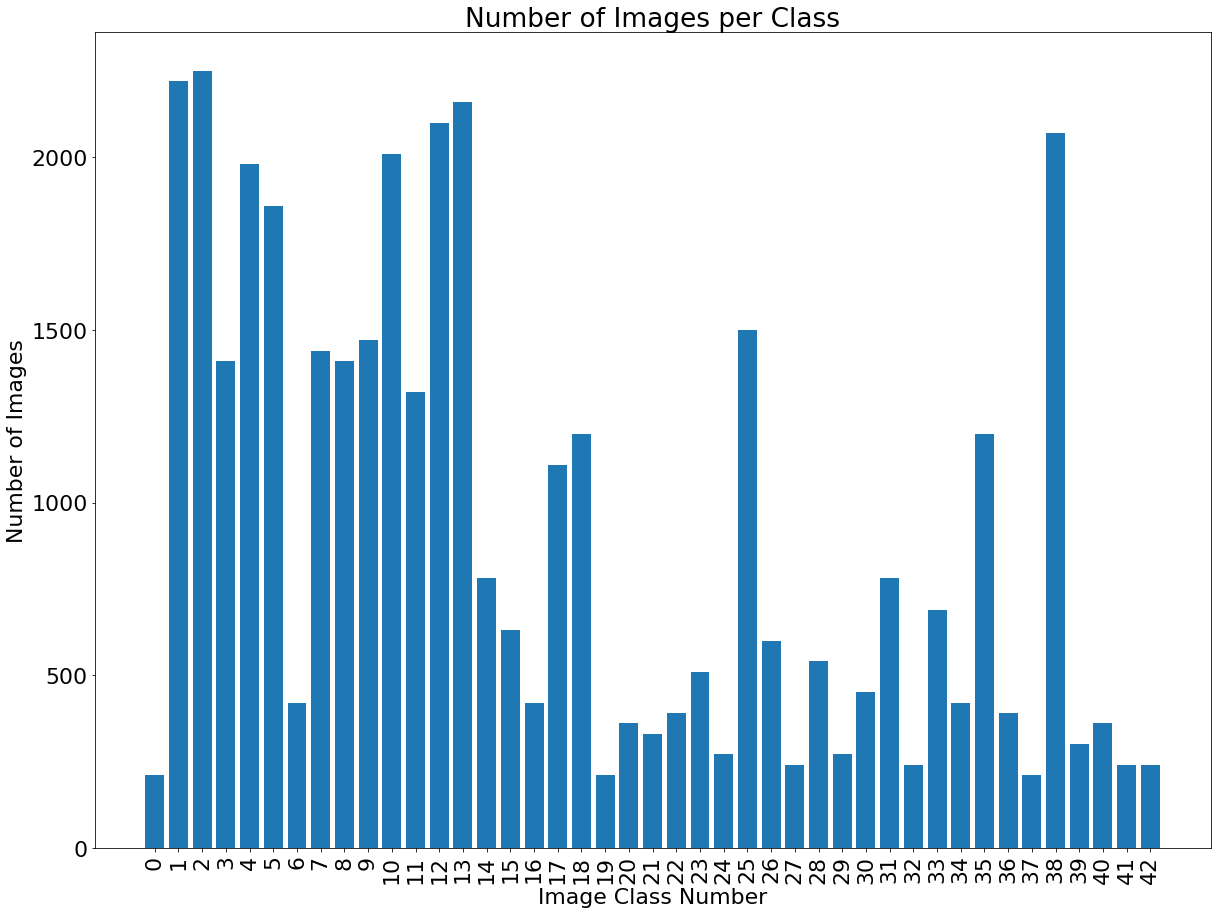

In [32]:
plt.figure(figsize = (20,15))
plt.bar(range(len(label_count)), label_count, align='center')
plt.title('Number of Images per Class')
plt.ylabel('Number of Images')
plt.xlabel('Image Class Number')
plt.xticks(label_order, label_order, rotation=90)
plt.rcParams.update({'font.size': 22})
plt.show()


# plt.figure(figsize=(10,10))
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.legend(['train', 'val'], loc='upper left')

# The Model
* The VGG 16 model is downloaded
* Input shape is customised to the target shape
* The model is frozen, so the existing network is not trained - this is imperitive to transfer learning

In [63]:
# Import model without a classification layer (for transfer learning)
vgg_model = VGG16(weights="imagenet", include_top=False, input_shape=(im_width, im_height, 3))

# vgg_model = tf.keras.models.load_model('input/vgg16-weights/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5')

# Freeze existing model
vgg_model.trainable = False


# The Extra Layers
* Further layers are added to VGG16
* These layers will be trained to detect patterns in the GTSRB dataset

In [64]:
# batch_norm_l     = layers.BatchNormalization()
flatten_layer    = layers.Flatten()
# dense_layer1     = layers.Dense(256, activation='relu', kernel_regularizer='l1')
dense_layer1     = layers.Dense(1024, activation='relu')
dense_layer2     = layers.Dense(256, activation='relu')
# prediction_layer = layers.Dense(43, activation='softmax')
# dense_layer      = layers.Dense(512, activation='relu')
# batchnorm_layer  = layers.BatchNormalization()
# dropout_layer    = layers.Dropout(rate=0.2)
prediction_layer = layers.Dense(43, activation='softmax')


model = models.Sequential([
    vgg_model,
    flatten_layer,
#     dense_layer,
#     dropout_layer,
    dense_layer1,
    dense_layer2,
#     batchnorm_layer,
#     dropout_layer,
    prediction_layer
])
#     vgg_model,
#     flatten_layer,
#     dense_layer1,
#     dense_layer2,
#     prediction_layer

In [65]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 3, 3, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 1024)              4719616   
_________________________________________________________________
dense_7 (Dense)              (None, 256)               262400    
_________________________________________________________________
dense_8 (Dense)              (None, 43)                11051     
Total params: 19,707,755
Trainable params: 4,993,067
Non-trainable params: 14,714,688
_________________________________________________________________


# Run the model
* Model is running using the class weight calculated above.
* A early stopping callback is implemented to stop training if no progress is made for 7 epochs

In [83]:
from tensorflow.keras.callbacks import EarlyStopping

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)


es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5,  restore_best_weights=True)

history = model.fit(data_train, epochs=10, validation_data=data_valid, batch_size=128, callbacks=[es], class_weight=reclassed_dict)

Epoch 1/10
858/858 [==============================] - 59s 68ms/step - loss: 241.9603 - accuracy: 0.9290 - val_loss: 1.7503 - val_accuracy: 0.6784
Epoch 2/10
858/858 [==============================] - 47s 55ms/step - loss: 215.2130 - accuracy: 0.9375 - val_loss: 1.9765 - val_accuracy: 0.6699
Epoch 3/10
858/858 [==============================] - 46s 54ms/step - loss: 168.4046 - accuracy: 0.9504 - val_loss: 1.9827 - val_accuracy: 0.6722
Epoch 4/10
858/858 [==============================] - 46s 54ms/step - loss: 161.9462 - accuracy: 0.9517 - val_loss: 2.1106 - val_accuracy: 0.6751
Epoch 5/10
858/858 [==============================] - 46s 54ms/step - loss: 152.1284 - accuracy: 0.9513 - val_loss: 1.9324 - val_accuracy: 0.6830
Epoch 6/10
858/858 [==============================] - 47s 55ms/step - loss: 149.3463 - accuracy: 0.9541 - val_loss: 2.1724 - val_accuracy: 0.6665
Epoch 7/10
858/858 [==============================] - 48s 56ms/step - loss: 121.3920 - accuracy: 0.9637 - val_loss: 2.3541 -

In [90]:
model.save("VG10-100-2DNN-(42).h5")

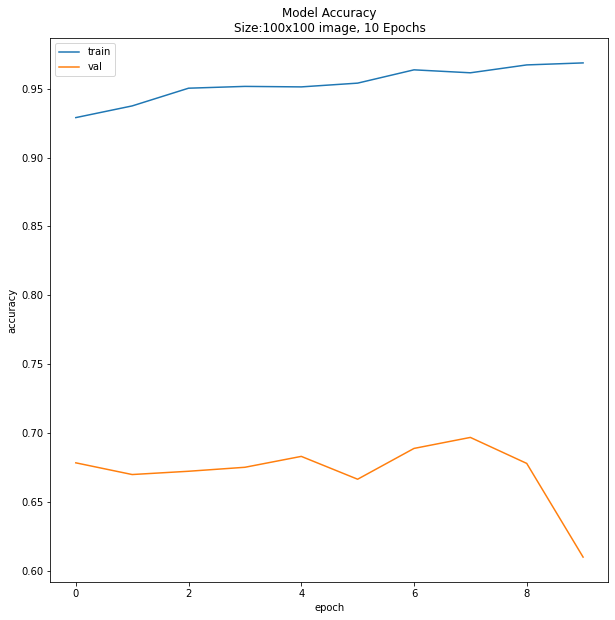

In [87]:
plt.figure(figsize=(10,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy\nSize:100x100 image, 10 Epochs')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

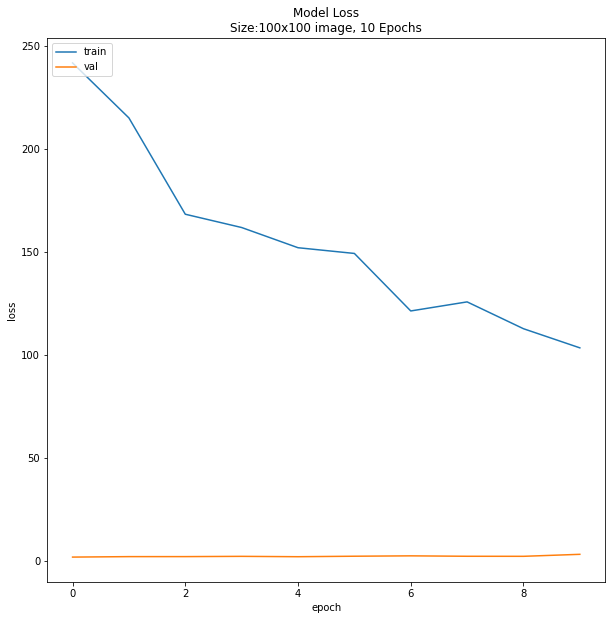

In [88]:
plt.figure(figsize=(10,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss\nSize:100x100 image, 10 Epochs')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Testing the model
* The model is tested and accuracy is determined
* A table is created to show prediction probability vs true probability

In [84]:
test_labels = df_test["ClassId"].values
test_imgs   = df_test["Path"].values

data_test = []
for img in test_imgs:
    try:
        test_im         = cv2.imread(data_path + img)
        image_fromarray = Image.fromarray(test_im, mode='RGB')
        resize_image    = image_fromarray.resize((im_height, im_width))
        data_test.append(np.array(resize_image))
    except:
        print("Error in " + img)

data_test = np.array(data_test)
data_test = data_test/255

In [7]:
# model = keras.models.load_model('/kaggle/input/vgg102442dnnnoacch5/VGG10-244-2DNN-(no-Acc).h5')

2022-12-23 14:54:41.854260: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [85]:
pred_array = model.predict(data_test)
pred_class = [int(list(data_train.class_indices.keys())[i]) for i in pred_array.argmax(axis=-1)]
print('Test Data accuracy: ', accuracy_score(test_labels, pred_class)*100)

2022-12-23 16:47:56.912762: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1515600000 exceeds 10% of free system memory.
2022-12-23 16:47:58.836215: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1515600000 exceeds 10% of free system memory.


Test Data accuracy:  42.0110847189232


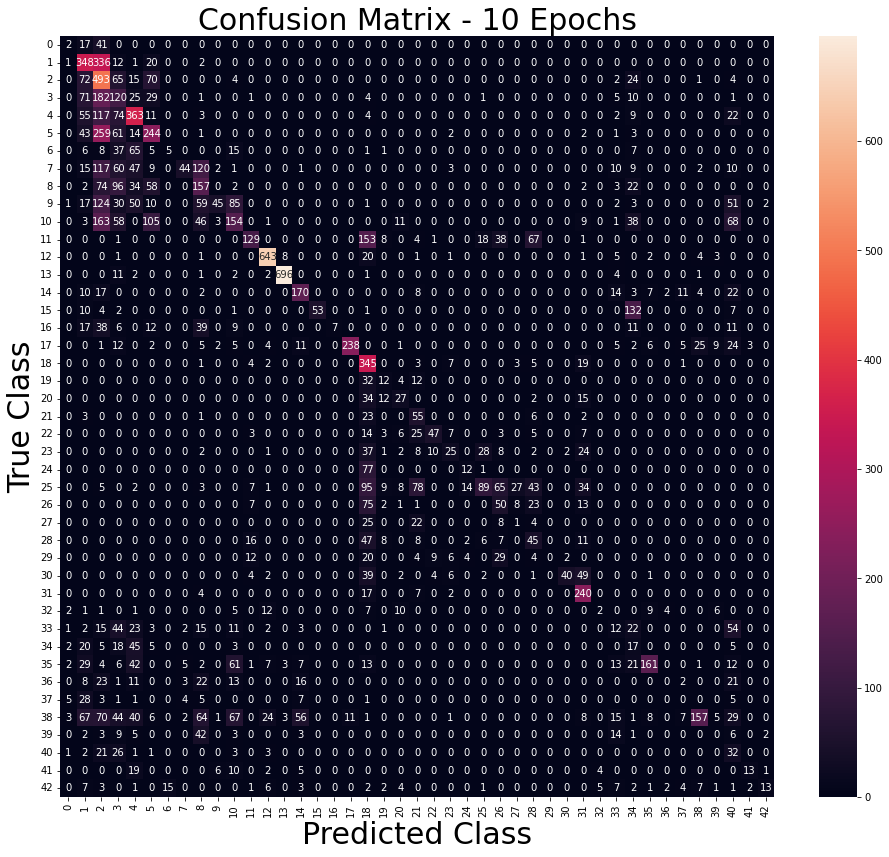

In [89]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
confusion_matrix  = confusion_matrix(test_labels, pred_class)
# cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix)
# cm_display.plot()
# plt.show()
# Plot confusion matrix in a beautiful manner

fig = plt.figure(figsize=(16, 14))
ax= plt.subplot()
sns.heatmap(confusion_matrix, annot=True, ax = ax, fmt = 'g'); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted Class', fontsize=30)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)
# ax.xaxis.set_ticklabels(class_names, fontsize = 10)
ax.xaxis.tick_bottom()

ax.set_ylabel('True Class', fontsize=30)
# ax.yaxis.set_ticklabels(class_names, fontsize = 10)
plt.yticks(rotation=0)

plt.title('Confusion Matrix - 10 Epochs', fontsize=30)

plt.savefig('ConMat24.png')
plt.show()

In [35]:
results_pd = pd.DataFrame({'True Label': test_labels})
prob_truth = []
prob_pred  = []

for i in range(pred_array.shape[0]): 
  prob_truth.append(pred_array[i][int_keys.index(test_labels[i])]*100)
  prob_pred.append(pred_array[i][int_keys.index(pred_class[i])]*100) 

results_pd['True Prob']  = prob_truth
results_pd['Prediction'] = pred_class
results_pd['Pred Prob']  = prob_pred


results_pd[0:20]

,True Label,True Prob,Prediction,Pred Prob
0,16,9.999955e+01,16,99.999547
1,1,6.064131e+01,1,60.641307
2,38,9.993995e+01,38,99.939954
3,33,3.565841e-09,12,82.365721
4,11,2.136319e+00,25,84.338760
5,38,9.999697e+01,38,99.996972
6,18,4.531513e+01,11,49.823451
7,12,1.742812e+00,13,98.210150
8,25,5.211430e+01,25,52.114296
9,35,2.973128e+00,17,97.014755
